## Model Iterations 

### Goal
- To automate model iterations for shortlisted zipcodes
- Build models
- use models to predict on test data
- Filter out ill performing models
- Retrain models on the entire time series?
- Make future Forecasts
- Caluculate ROI for one year and select top 5


In [43]:
%load_ext autoreload
%autoreload 2

In [64]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.easter import easter
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as mse

#### Firstly 
Let's subset the dataframe to only include Chicago Metro Area, calculate 5year ROI, 2 year ROI and creates a list of top regions, and convert the wide format to long and returns a time series dataframe with zipcodes as columns 

In [2]:
#load df
df = cfs.load_df()

#subset for chicago metro area
chicago_df = df[(df['Metro'] == 'Chicago')]

#calculate ROI for 5years and 2 years
chicago_df['ROI_5yrs'] = ((chicago_df['2018-04'] - chicago_df['2013-04'])/chicago_df['2013-04'])*100
chicago_df['ROI_2yrs'] = ((chicago_df['2018-04'] - chicago_df['2016-04'])/chicago_df['2016-04'])*100

#identify zipcodes based on top ROI for 5 and 2 year time period
top_15_ROI5 = chicago_df.sort_values('ROI_5yrs', ascending=False)[:15].RegionName
top_15_ROI2 = chicago_df.sort_values('ROI_2yrs', ascending=False)[:15].RegionName

#collect column names
colnames = list(df.columns)
#isolate time period columns alone
colnames = colnames[7:]
#replacing NaNs as 1 for now to accomadate further df manipulation
for colname in colnames:
    df[colname].fillna(value=1, inplace=True)

#transforming from wide to long
melted_df = cfs.melt_data(df)

#### Combining the top zipcodes based Return on Investment for the two time periods (2 years and 5years)

In [6]:
roi5_regions = top_15_ROI5.values
roi2_regions = top_15_ROI2.values

Removing repeats here

In [7]:
regions = []
for region in roi5_regions:
    regions.append(region)
for region in roi2_regions:
    if region not in regions:
        regions.append(region)
len(regions)

27

Creating a new dataframe to only include values for identified Zipcodes

In [8]:
chicago_top_27 = pd.DataFrame()
chicago_top_27['time'] = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')
chicago_top_27.set_index('time', inplace=True)
for region in regions:
    chicago_top_27[region] = melted_df[melted_df['RegionName'] == region].value.values

Subsetting for timeperiod after the housing crash in 2008, the market recovered around 2012 - 2013, including values from January 2013 onwards

In [12]:
data = chicago_top_27['2013':]

In [24]:
data.head()

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60456,60034,46327,60180,60633,46324,60099,46320,46394,60162
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,79100.0,67100.0,84500.0,88500.0,84500.0,75800.0,95500.0,86700.0,71600.0,140200.0,...,88300.0,136700.0,1.0,165300.0,84600.0,73400.0,84900.0,1.0,90200.0,113600.0
2013-02-01,78400.0,66600.0,83300.0,88500.0,83700.0,74200.0,91600.0,86800.0,71000.0,138800.0,...,89300.0,135800.0,1.0,165900.0,83800.0,73700.0,83900.0,1.0,89200.0,114400.0
2013-03-01,79600.0,64300.0,82000.0,89700.0,84200.0,74000.0,88200.0,86300.0,70600.0,139200.0,...,91500.0,133700.0,1.0,166800.0,83000.0,73800.0,82500.0,1.0,86300.0,115800.0
2013-04-01,81100.0,62400.0,80500.0,90900.0,85300.0,74900.0,85700.0,86200.0,70700.0,140300.0,...,93700.0,130800.0,1.0,167400.0,82100.0,74200.0,82600.0,1.0,84000.0,116900.0
2013-05-01,81400.0,60200.0,79100.0,91700.0,86000.0,76200.0,83600.0,86200.0,71100.0,142200.0,...,95100.0,129200.0,1.0,169100.0,80600.0,74600.0,81800.0,1.0,83800.0,118000.0


replacing 1s as NaN (the original entry)

In [38]:
for i in data:
    data[i].replace(1., np.NaN, inplace = True)

In [40]:
data.head()

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60456,60034,46327,60180,60633,46324,60099,46320,46394,60162
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,79100.0,67100.0,84500.0,88500.0,84500.0,75800.0,95500.0,86700.0,71600.0,140200.0,...,88300.0,136700.0,NaN,165300.0,84600.0,73400.0,84900.0,NaN,90200.0,113600.0
2013-02-01,78400.0,66600.0,83300.0,88500.0,83700.0,74200.0,91600.0,86800.0,71000.0,138800.0,...,89300.0,135800.0,NaN,165900.0,83800.0,73700.0,83900.0,NaN,89200.0,114400.0
2013-03-01,79600.0,64300.0,82000.0,89700.0,84200.0,74000.0,88200.0,86300.0,70600.0,139200.0,...,91500.0,133700.0,NaN,166800.0,83000.0,73800.0,82500.0,NaN,86300.0,115800.0
2013-04-01,81100.0,62400.0,80500.0,90900.0,85300.0,74900.0,85700.0,86200.0,70700.0,140300.0,...,93700.0,130800.0,NaN,167400.0,82100.0,74200.0,82600.0,NaN,84000.0,116900.0
2013-05-01,81400.0,60200.0,79100.0,91700.0,86000.0,76200.0,83600.0,86200.0,71100.0,142200.0,...,95100.0,129200.0,NaN,169100.0,80600.0,74600.0,81800.0,NaN,83800.0,118000.0


### Train Test Split
**Training data -> timeline: Jan 2013 to Oct 2017**

**Testing data -> timeline: Oct 2017 to April 2018**

In [47]:
def train_test_split(df, train_start, test_start):
    
    train = df[train_start:test_start]
    test = df[test_start:]

    return train, test

In [48]:
train, test = train_test_split(data, '2013-01-01', '2017-10-01')

### Grid Search for optimal SARIMA orders

In [59]:
sarimax_orders = []
for i in range(len(regions)):
    results = {}
    import itertools
    p = q = d = range(0, 2)
    pdq = list(itertools.product(p, d , q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    print('Orders and AIC Results...')
    #for i in pdq:
    #    for s in seasonal_pdq:
    #        print('SARIMAX: {} x {}'.format(i, s))
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod =SARIMAX(train.iloc[:, i],order=param,seasonal_order=param_seasonal,
                             enforce_stationarity=False,enforce_invertibility=False)
                result = mod.fit()
                results[result.aic] = (param, param_seasonal)
                print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,result.aic))
            except: 
                print('hello')
                continue
    min_ = np.min([x for x in results.keys() if str(x) != 'nan'])
    sarimax_orders.append(results[min_])

Examples of parameter for SARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1499.2096584151604
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:86944.36783777668
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1014.4331334010394
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1278.8583356449337
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:955.3502051597953
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:965.5166027216608
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:711.6741999147864
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1107.3340716135858
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1436.0605249965001
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:79594.54625665542
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:998.2651571245963
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:nan
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1169.8757715314036
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1180.4237969805129
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:742.4134596669319
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:nan
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:992.0157970042696
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:775.6186107901452
ARIMA(0, 1, 0)x(0, 1, 0, 12) - 

In [60]:
sarimax_orders

[((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12))]

##### Time to train sarima models with identified orders

In [62]:
sarima_test_predictions = []
sarima_models = []
for i in range(len(regions)):
    model = SARIMAX(train.iloc[:, i], order=sarimax_orders[i][0],
                    seasonal_order=sarimax_orders[i][1],
                    enforce_invertibility=False, enforce_stationarity=False).fit()
    test_preds = model.predict(start=test.iloc[:, i].index[0],
                               end=test.iloc[:, i].index[-1], typ='levels')
    sarima_test_predictions.append(test_preds)
    sarima_models.append(model)

Visualizing the predictions for test data along with the actual values

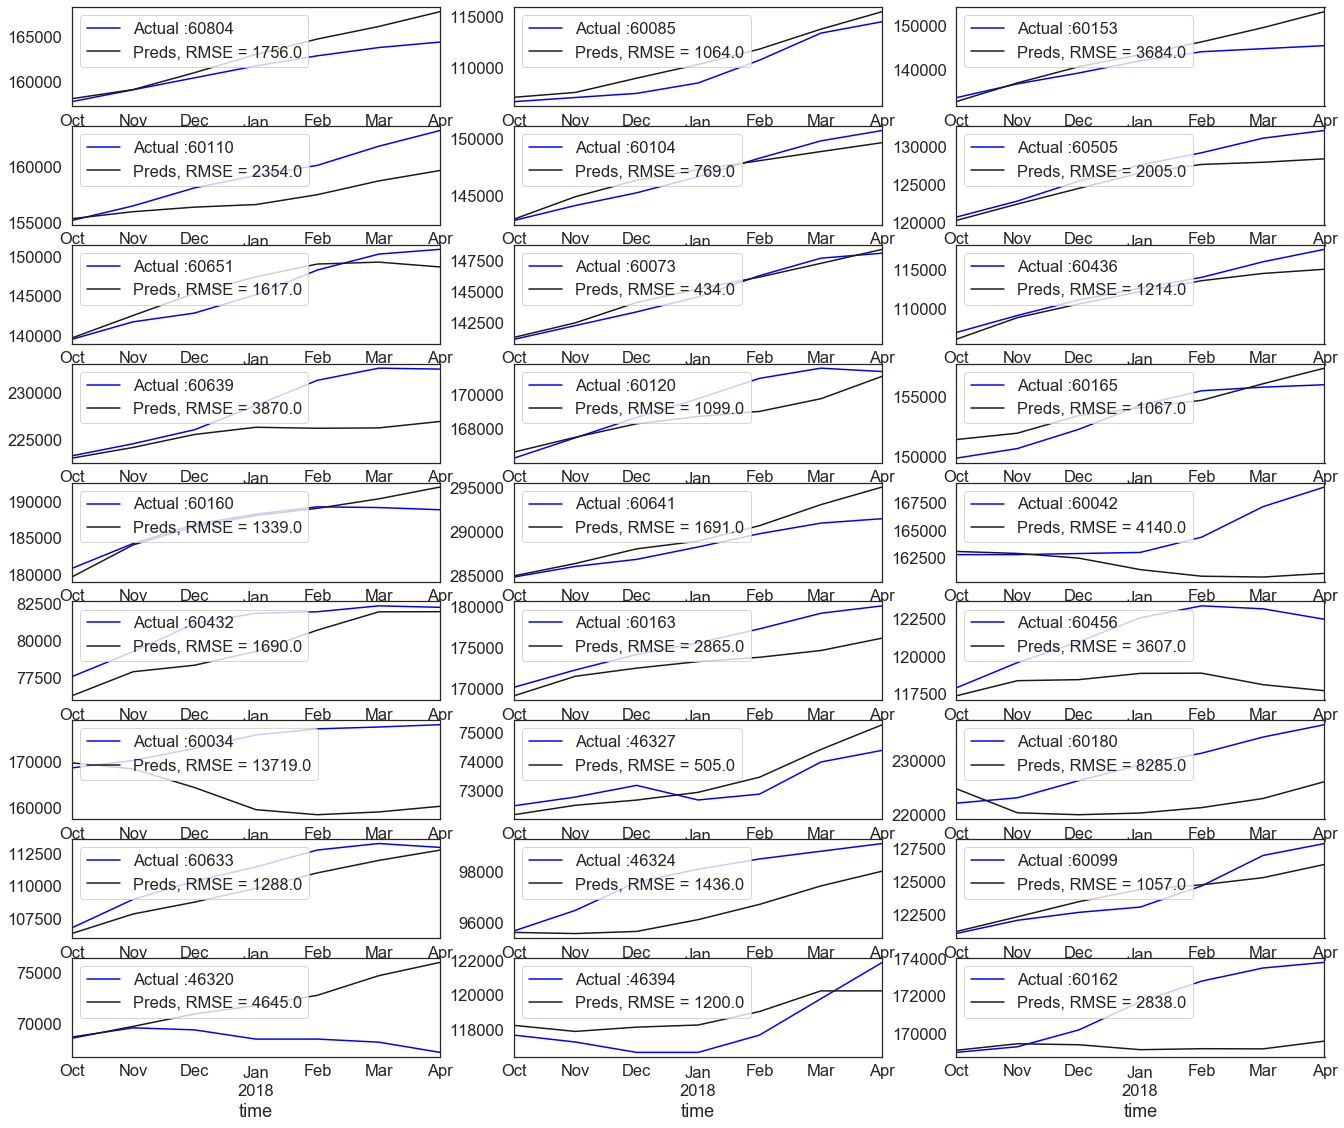

In [72]:
sns.set(font_scale=1.5)
sns.set_style('white')
pd.plotting.register_matplotlib_converters()
fig, ax = plt.subplots(9, 3, figsize=(20, 18))
i = 0
for row in range(9):
    for col in range(3):
        err = round(np.sqrt(mse(test.iloc[:, i], sarima_test_predictions[i])),0)
        test.iloc[:, i].plot(ax=ax[row][col], color='blue',
                             label='Actual :' + str(regions[i]))
        sarima_test_predictions[i].plot(ax=ax[row][col], color='k',
                                        label='Preds, RMSE = ' + str(err))
        ax[row][col].legend(loc='upper left')
        i += 1

setting RMSE threshold of 2500 and filtering out ill performing models (as well as zip codes)

In [75]:
indices = []
rmse = []
for i in range(len(regions)):
    err = round(np.sqrt(mse(test.iloc[:, i], sarima_test_predictions[i])),0)
    rmse.append(err)
    if err < 2500:
        indices.append(i)

In [76]:
np.sort(rmse)

array([  434.,   505.,   769.,  1057.,  1064.,  1067.,  1099.,  1200.,
        1214.,  1288.,  1339.,  1436.,  1617.,  1690.,  1691.,  1756.,
        2005.,  2354.,  2838.,  2865.,  3607.,  3684.,  3870.,  4140.,
        4645.,  8285., 13719.])

In [81]:
useful_models = []
for i in range(len(regions)):
    if i in indices:
        useful_models.append(sarima_models[i])

In [82]:
codes = []
params_list = []
for i in range(len(regions)):
    if i in indices:
        codes.append(regions[i])
        params_list.append(sarimax_orders[i])

In [86]:
codes

[60804,
 60085,
 60110,
 60104,
 60505,
 60651,
 60073,
 60436,
 60120,
 60165,
 60160,
 60641,
 60432,
 46327,
 60633,
 46324,
 60099,
 46394]

In [87]:
params_list

[((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12))]

In [88]:
current_aics = {}
for i in range(len(regions)):
    model = SARIMAX(train.iloc[:, i], order=sarimax_orders[i][0], seasonal_order=sarimax_orders[i][1], enforce_invertibility=False, enforce_stationarity=False).fit()
    current_aics[regions[i]] = model.aic

In [89]:
current_aics

{60804: 499.0098865644672,
 60085: 529.8033324999615,
 60153: 525.6235793104161,
 60110: 503.85750494350043,
 60104: 504.91974310586863,
 60505: 503.7105657072831,
 60651: 538.9091032810707,
 60073: 475.56667886868644,
 60436: 506.5347693363978,
 60639: 526.5377664920347,
 60120: 499.62821935715573,
 60165: 528.7395145527961,
 60160: 547.6992935282642,
 60641: 533.2363858534837,
 60042: 529.0095241514402,
 60432: 550.4485337048176,
 60163: 528.2436758191496,
 60456: 543.0388486419567,
 60034: 568.0314220815721,
 46327: 507.53203006684305,
 60180: 575.7279668851969,
 60633: 524.5786805018075,
 46324: 502.84107309838,
 60099: 519.6436386794371,
 46320: 531.3432913671845,
 46394: 547.6567452096433,
 60162: 511.75342827477664}

In [95]:
data.head(3)

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60456,60034,46327,60180,60633,46324,60099,46320,46394,60162
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,79100.0,67100.0,84500.0,88500.0,84500.0,75800.0,95500.0,86700.0,71600.0,140200.0,...,88300.0,136700.0,NaN,165300.0,84600.0,73400.0,84900.0,NaN,90200.0,113600.0
2013-02-01,78400.0,66600.0,83300.0,88500.0,83700.0,74200.0,91600.0,86800.0,71000.0,138800.0,...,89300.0,135800.0,NaN,165900.0,83800.0,73700.0,83900.0,NaN,89200.0,114400.0
2013-03-01,79600.0,64300.0,82000.0,89700.0,84200.0,74000.0,88200.0,86300.0,70600.0,139200.0,...,91500.0,133700.0,NaN,166800.0,83000.0,73800.0,82500.0,NaN,86300.0,115800.0


In [93]:
new_aics = {}
for i, code in enumerate(codes):
    model = SARIMAX(data.loc[:, code], order=params_list[i][0],
                    seasonal_order=params_list[i][1],
                    enforce_invertibility=False,
                    enforce_stationarity=False).fit()
    new_aics[code] = model.aic

In [94]:
new_aics

{60804: 588.9217481725924,
 60085: 624.9134744879655,
 60110: 595.8206126136638,
 60104: 596.939890310223,
 60505: 599.3840523391317,
 60651: 638.0543180685326,
 60073: 553.2933696786573,
 60436: 598.1238101755829,
 60120: 595.9450394251235,
 60165: 627.0632669041102,
 60160: 645.1820544327178,
 60641: 631.7054902288346,
 60432: 650.0368271401668,
 46327: 600.3609221014082,
 60633: 619.3523665419516,
 46324: 594.880785627409,
 60099: 619.6064129940941,
 46394: 645.563439643788}

Training on entire set with old parameters made the aics get a little higher for a few of our codes

Let's redo another grid search with full data and identified zipcodes(down to 18 from 27)

In [96]:
new_sarimax_orders = []
for i, code in enumerate(codes):
    results = {}
    import itertools
    p = q = d = range(0, 2)
    pdq = list(itertools.product(p, d , q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    print('Orders and AIC Results...')
    #for i in pdq:
    #    for s in seasonal_pdq:
    #        print('SARIMAX: {} x {}'.format(i, s))
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(data.loc[:, code],order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
                result = mod.fit()
                results[result.aic] = (param, param_seasonal)
                print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,result.aic))
            except: 
                print('hello')
                continue
    min_ = np.min([x for x in results.keys() if str(x) != 'nan'])
    new_sarimax_orders.append(results[min_])

Orders and AIC Results...
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1661.191651423716
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1327.6515862621914
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1148.228867525199
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:879.5709014272365
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1077.3516120990232
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1104.9307041372138
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:833.1412139927581
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:774.460960407039
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1593.5845164077732
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1369.4334366241576
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1130.6794626906492
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:829.6016003240102
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1325.1899421485139
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1276.3953725943406
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:870.1381297632727
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:824.2349779505487
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1094.668034121408
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:876.4857602239456
ARIMA(0, 1, 0

In [97]:
new_sarimax_orders

[((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12))]

In [98]:
best_aics = {}
for i, code in enumerate(codes):
    model = SARIMAX(data.loc[:, code], order=new_sarimax_orders[i][0],
                    seasonal_order=new_sarimax_orders[i][1],
                    enforce_invertibility=False,
                    enforce_stationarity=False).fit()
    best_aics[code] = model.aic

In [99]:
best_aics

{60804: 588.9217481725924,
 60085: 611.0298176339461,
 60110: 559.0267266256456,
 60104: 579.8986895924479,
 60505: 578.1299032978603,
 60651: 620.2509835820837,
 60073: 553.2933696786573,
 60436: 564.6881564925551,
 60120: 564.935062726023,
 60165: 627.0632669041102,
 60160: 629.4619029851814,
 60641: 614.4632089524798,
 60432: 627.880511170375,
 46327: 600.3609221014082,
 60633: 593.5484876779134,
 46324: 567.9238144302549,
 60099: 602.3189198867592,
 46394: 629.8889419810729}

##### Nice! there was slight improvement in all the aic scores for our new models
### Time for forecasts

In [100]:
forecasts = {}
for i, code in enumerate(codes):
    model = SARIMAX(data.loc[:, code], order=new_sarimax_orders[i][0],
                    seasonal_order=new_sarimax_orders[i][1],
                    enforce_invertibility=False,
                    enforce_stationarity=False).fit()
    forecasts[code] = model.forecast(steps=12).values

In [101]:
forecasts

{60804: array([165133.75510942, 166047.72206733, 167096.46499588, 168005.75268445,
        168772.61973004, 169705.61753837, 171043.6300291 , 172643.48625319,
        174318.75544043, 175749.08732105, 176920.44380451, 178019.98526179]),
 60085: array([116043.05299525, 117636.27864931, 118653.98161885, 119486.75051729,
        120108.55183881, 120406.13764847, 121902.49395452, 124124.62328807,
        126242.62847433, 128400.17991483, 130776.32263499, 132518.83402516]),
 60110: array([163962.14579923, 164712.20310201, 165966.59277236, 167310.73795634,
        168652.52758969, 169931.35591089, 171446.05017555, 172898.97019132,
        173871.24693736, 174935.3539521 , 176601.36100399, 177836.2432947 ]),
 60104: array([151570.38685526, 152263.51813729, 152671.22433945, 153396.92812224,
        154687.75996572, 156180.39068724, 157347.09396543, 158326.49932886,
        159099.14383964, 159712.28104424, 160512.36228762, 161579.94113386]),
 60505: array([132689.38721141, 133299.75316021, 133

In [103]:
data.iloc[-1, 1]

114500.0

In [109]:
data.iloc[-1, 10]

171400.0

In [110]:
indices

[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 19, 21, 22, 23, 25]

In [112]:
roi_forecasts = {}
for i, code in enumerate(indices):
    roi = ((forecasts[codes[i]][-1] - data.iloc[-1, code])/data.iloc[-1, code]) * 100
    roi_forecasts[codes[i]] = roi

In [113]:
roi_forecasts

{60804: 8.284662567999645,
 60085: 15.736972947741043,
 60110: 8.968286332536385,
 60104: 7.219602610392842,
 60505: 10.150862658004883,
 60651: 10.139649129898757,
 60073: 5.673188586471117,
 60436: 10.75474381666315,
 60120: 5.610190925258897,
 60165: 8.396980978498789,
 60160: 8.292004997085098,
 60641: 5.030494852083288,
 60432: 9.454555061789769,
 46327: 13.437037431953442,
 60633: 8.939916516022137,
 46324: 8.051569809001045,
 60099: 8.9830699522753,
 46394: 8.139553150758552}

In [119]:
forecasts

{60804: array([165133.75510942, 166047.72206733, 167096.46499588, 168005.75268445,
        168772.61973004, 169705.61753837, 171043.6300291 , 172643.48625319,
        174318.75544043, 175749.08732105, 176920.44380451, 178019.98526179]),
 60085: array([116043.05299525, 117636.27864931, 118653.98161885, 119486.75051729,
        120108.55183881, 120406.13764847, 121902.49395452, 124124.62328807,
        126242.62847433, 128400.17991483, 130776.32263499, 132518.83402516]),
 60110: array([163962.14579923, 164712.20310201, 165966.59277236, 167310.73795634,
        168652.52758969, 169931.35591089, 171446.05017555, 172898.97019132,
        173871.24693736, 174935.3539521 , 176601.36100399, 177836.2432947 ]),
 60104: array([151570.38685526, 152263.51813729, 152671.22433945, 153396.92812224,
        154687.75996572, 156180.39068724, 157347.09396543, 158326.49932886,
        159099.14383964, 159712.28104424, 160512.36228762, 161579.94113386]),
 60505: array([132689.38721141, 133299.75316021, 133

In [128]:
forecast_df = pd.DataFrame(forecasts,index=pd.date_range(start='2018-04-01',
                                                         end='2019-03-01',
                                                         freq='MS'))

In [124]:
roi_sorted = sorted(roi_forecasts.items(), key= lambda x: x[1], reverse=True)

In [129]:
roi_sorted[:9]

[(60085, 15.736972947741043),
 (46327, 13.437037431953442),
 (60436, 10.75474381666315),
 (60505, 10.150862658004883),
 (60651, 10.139649129898757),
 (60432, 9.454555061789769),
 (60099, 8.9830699522753),
 (60110, 8.968286332536385),
 (60633, 8.939916516022137)]

In [130]:
top_5_df = forecast_df.loc[:, [46327, 60505, 60436, 60651, 60633]]

In [131]:
top_5_df

,46327,60505,60436,60651,60633
2018-04-01,74365.080342,132689.387211,118485.915173,151225.779061,113214.446077
2018-05-01,74749.540478,133299.753160,119095.150779,151493.596718,114261.819139
2018-06-01,75392.204942,133577.343493,119854.674363,151683.137948,115549.238089
2018-07-01,75821.007915,133868.459722,120812.212056,152195.388146,116332.872188
2018-08-01,76580.987092,134638.890713,121899.989859,153298.602132,116812.928401
2018-09-01,77918.679520,135792.315441,123098.800177,155482.819081,117761.673394
2018-10-01,79178.298573,137590.933494,124411.192850,157745.463387,119129.579451
2018-11-01,80316.342254,139840.639674,125880.364518,159132.156074,120253.783055
2018-12-01,81252.539889,141756.831641,127259.227924,161367.260447,121237.303791
2019-01-01,82264.153644,143166.081019,128403.851205,164134.228299,122221.765070


In [ ]:
preds = {}
for i, code in enumerate(codes):
    model = SARIMAX(data.loc[:, code], order=new_sarimax_orders[i][0],
                    seasonal_order=new_sarimax_orders[i][1],
                    enforce_invertibility=False,
                    enforce_stationarity=False).fit()
    preds[code] = model.predict(typ='levels')

In [ ]:
preds_df = pd.DataFrame(preds, index=pd.date_range(start='2013-01-01',
                                                   end='2018-04-01',
                                                  freq='MS'))
preds_df = preds_df['2015':]

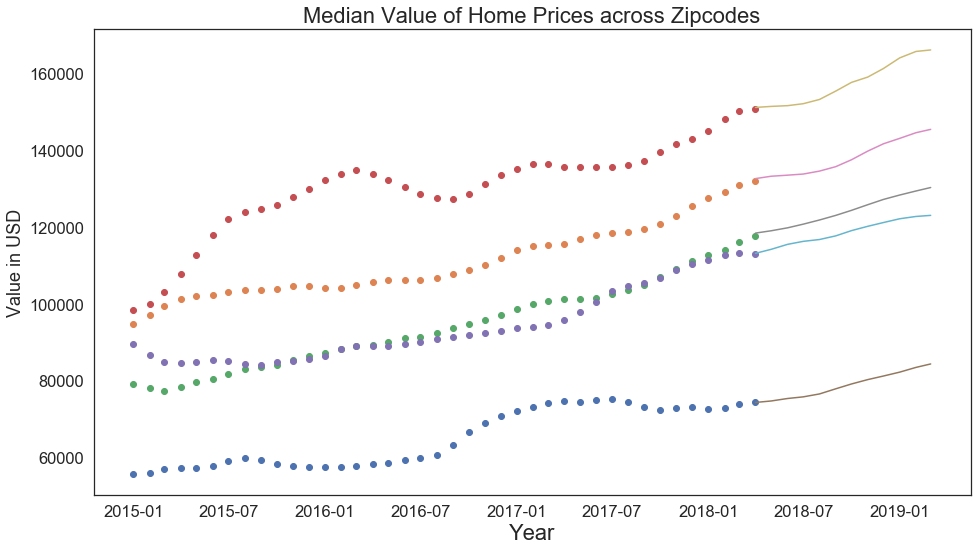

<Figure size 432x288 with 0 Axes>

In [139]:
sns.set(font_scale=1.5)
sns.set_style('white')
plt.figure(figsize=(14,8))

plt.plot(data['2015':].index, 
         data.loc['2015':, [46327, 60505, 60436, 60651, 60633]],
        marker='o', ls='')
plt.plot(forecast_df.index, 
         forecast_df.loc[:, [46327, 60505, 60436, 60651, 60633]])
plt.xlabel('Year', fontsize=22)
plt.ylabel('Value in USD', fontsize=18)
plt.title('Median Value of Home Prices across Zipcodes', fontsize=22)
plt.show()
plt.savefig('market');

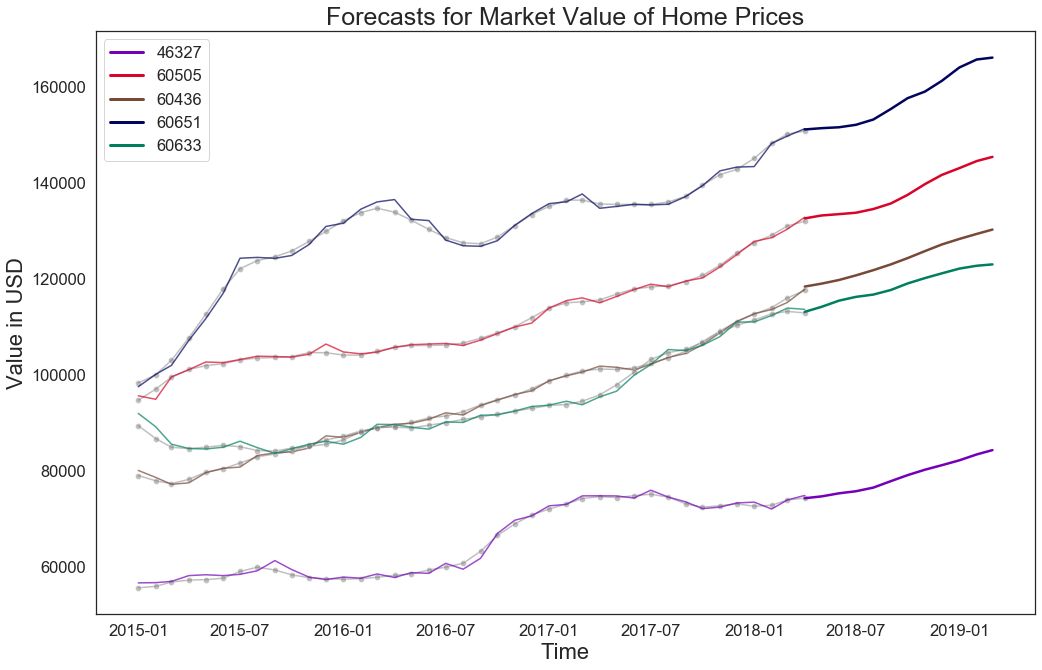

<Figure size 1080x720 with 0 Axes>

In [190]:
recs = [46327, 60505, 60436, 60651, 60633]
palette = ['#7400b8','#d90429','#774936','#03045e','#007f5f']

from matplotlib.lines import Line2D
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})
splots = []
for i, rec in enumerate(recs):
    sns.lineplot(data['2015':].index, 
                 data.loc['2015':, rec],
                 marker='o',
                 color='gray',
                alpha=0.5)
    sns.lineplot(preds_df.index, 
                 preds_df.loc[:, rec],
                 color=palette[i],
                lw=1.5, alpha=0.7)
    sns.lineplot(x=forecast_df[rec].index,
                 y=forecast_df[rec].values,
                color=palette[i],
                lw=2.5)

legend_elements = []
for i, rec in enumerate(recs):
    legend_elements.append(Line2D([0], [0], color=palette[i], lw=3, label=rec))
                   
plt.legend(handles=legend_elements)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Value in USD', fontsize=22)
plt.title('Forecasts for Market Value of Home Prices', fontsize=25)
plt.show()
plt.tight_layout()
plt.savefig('forecasts.png');

In [ ]:
import folium
folium.Map(
    location=[40.6331, -89.3985],
    zoom_start=7
)
locations = [41.6291, -87.5050], [41.7580, -88.2948], [41.4960, -88.1194], [41.9025, -87.7419], [41.6602, -87.5643]